<a href="https://colab.research.google.com/github/jcandane/TensorNetworkX/blob/main/TTN_NN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import numpy as np
import scipy
import scipy.sparse.linalg
import scipy.sparse as sparse
import matplotlib.pyplot as plt

try:
    import pyftt
except:
    !pip install pyftt
    import pyftt

try:
    import networkx as nx
except:
    !pip install networkx
    import networkx as nx

try:
    import network2tikz
    from network2tikz import plot
except:
    !pip install network2tikz ### https://pypi.org/project/network2tikz/
    import network2tikz
    from network2tikz import plot  

def Heisenberg_dense(J_ij): ###good for arb. J_ij  ### Explicit, Lie-Algebra....

    sites = len(J_ij)
    σ_xab = np.array([ [[0,1],[1,0]], [[0,-1j],[1j,0]], [[1,0],[0,-1]] ])
    I_ab  = np.eye(2)

    S_i = np.zeros((sites, 3, 2**sites, 2**sites),dtype=np.complex128)
    for i in range(sites):
        if i==0:
            S = σ_xab
        else:
            S = I_ab
        for j in range(1,sites):
            if j==i:
                S = np.kron(S, σ_xab)
            else:
                S = np.kron(S, I_ab)
        S_i[i] = S

    H    = 1/4* (np.einsum("ij,ixAB,jxBC -> AC", J_ij, S_i, S_i, optimize=True))
    E, v = np.linalg.eigh(H) ## make this sparse.....

    return E[0], v[0]

# premade def/functions codes

In [2]:
def su(N, JW=False):
    """
    j.candanedo 4/11/2023
    GIVEN:  N , dimension of Lie-Algebra
            JW, choice for Jordan-Wigner Transformation
    GET:    sparse-array (t=array-of-tuples, T=data-array, out_shape=dense-array-shape)
    """

    if JW:
        sparse_elements = int( N*(N-1) + N*(N+1)/2 - 1 )
        T = np.zeros(sparse_elements)
    else:
        sparse_elements = int( 2*N*(N-1) + N*(N+1)/2 - 1 )
        T = np.zeros(sparse_elements, dtype=complex)
    i = 0 ## sparse-array entry
    j = 0 ## generator-number
    t = np.zeros((sparse_elements,3), dtype=np.int32)
    for n in range(N-1): ## loop over Cartan-generators
        for m in range(n+1): ## loop over off-diagonals
            ## real generator
            t[i] = np.array([j, m, n+1])
            T[i] = 1.
            i+=1
            if JW:
                j+=1
            t[i] = np.array([j, n+1, m])
            T[i] = 1.
            i+=1
            j+=1

            ## imag generator
            if not JW:
                t[i] = np.array([j, m, n+1]) 
                T[i] = -1.j
                i+=1
                t[i] = np.array([j, n+1, m])
                T[i] =  1.j
                i+=1
                j+=1

        ## constant for Cartan-genorators.
        C = 1/np.sqrt( (n+1)*(n+2)/2 ) ## constant for Cartan-genorators.
        for m in range(n+1): ## loop over sparse Cartan-generator elements
            ## place-in Cartan-elements
            t[i] = np.array([j, m, m])
            T[i] = C
            i+=1
        ## last element of Cartan generator
        t[i] = np.array([j, n+1, n+1])
        T[i] = -(n+1)*C
        i+=1
        j+=1
    out_shape = np.array([j,N,N])
    return t, T, out_shape

def Dense_to_Sparse(A, tol=1.E-8):
    """
    Given:  A (arbitrary dimensional numpy.array)
            tol (tolerance, range of values which may be set to "0")
    Get:    sparse_array_object
    """
    indices=np.asarray(np.where(np.abs(A) >= tol))
    return pyftt.sparse_array(indices=indices, data=A[tuple( indices )], shape=np.asarray(A.shape), wellordered=True)

def integers_to_tuplesX(numbers, dense_shape):
    """
    GIVEN:  integer/integers (0d/1d int/int-numpy-array)
            dense_shape (1d numpy array, shape of the dense representation)
    GET:    list_of_tuples (2d int numpy int array)
    """

    ### 
    #dense_shape = np.roll(np.flip(dense_shape), 1)
    shapez    = np.roll(np.flip(dense_shape), 1)
    shapez[0] = 1
    shapez    = np.flip(np.cumprod(shapez))

    ### 
    numbers   = np.array([numbers]).flatten()
    out_tuple = np.zeros((len(numbers),len(dense_shape)), dtype=np.int64)
    for i in range(len(shapez)): ## for each column in new-shape
        out_tuple[:,i] = numbers // (shapez[i])
        numbers        = np.mod( numbers, (shapez[i]))
    return out_tuple

def tuples_to_integersX(list_of_tuples, dense_shape):
    """
    GIVEN:  list_of_tuples (1d/2d int numpy array)
            dense_shape (1d numpy array, shape of the dense representation)
    GET:    1d array of ints xor int (corresponding to pair-function)
    """
    dense_shape = np.roll(np.flip(dense_shape), 1)
    shapez    = 1*dense_shape
    shapez[0] = 1
    return list_of_tuples @ (np.flip(np.cumprod(shapez)))

def Reshape(list_of_tuples, old_shape, reshapinglist):

    ###### fit loose numbers into lists...[[1,0],[2,4],3] -> [[1,0],[2,4],[3]]
    for i in range(len(reshapinglist)):
        if isinstance(reshapinglist[i], int) or isinstance(reshapinglist[i], np.int32):
            reshapinglist[i] = np.array([reshapinglist[i]])
    ######

    ###### find:  [expansion] whether to expand (get tuples) xor contract (get integers).
    ######        [new_shape] shape of output sparse-tensor
    ######        [coln_shapes] shapes of each column (in new sparsetensor) to preform reshape 
    coln_shapes = []
    expansion   = []
    new_shape   = []
    for i in range(len(reshapinglist)):
        if len(reshapinglist[i]) > 1:
            if isinstance(reshapinglist[i][1], list):
                coln_shapes.append(reshapinglist[i][1])
                expansion.append(True)
                new_shape.append(reshapinglist[i][1])
            else:
                coln_shapes.append(old_shape[reshapinglist[i]])
                expansion.append(False)
                new_shape.append(np.prod(old_shape[reshapinglist[i]]))
        else:
            coln_shapes.append(old_shape[reshapinglist[i]])
            expansion.append(False)
            new_shape.append(np.prod(old_shape[reshapinglist[i]]))
    new_shape = np.asarray(new_shape)   
    ######

    ###### FINALLY, DETERMINE NEW_INDEX ARRAY
    new_index_array = np.zeros((len(new_shape), list_of_tuples.shape[1]) , dtype=np.int64)
    coln=0
    j=0
    for i in range(len(expansion)):
        if expansion[i]:
            l = (len(reshapinglist[i][1]))
            new_index_array[j:(j+l),:] = integers_to_tuplesX(list_of_tuples[reshapinglist[i][0],:], np.asarray(coln_shapes[i]) ).T
            j+=l
        else:
            new_index_array[j,:] = tuples_to_integersX(list_of_tuples[reshapinglist[i],:].T, coln_shapes[i])
            j+=1
    ######

    return new_index_array, new_shape

def iargsort(r):
    """
    see https://stackoverflow.com/questions/2483696/undo-or-reverse-argsort-python
    A  = np.random.rand(17)
    As = np.sort(A)
    print(A)
    print(As)
    print(As[iargsort(A)])
    """
    i        = np.argsort(r)
    i_rev    = np.zeros(len(r), dtype=int)
    i_rev[i] = np.arange(len(r))
    return i_rev


def cansum(D, label_D, S, label_S):
    """
    Contract a Dense and Sparse array (not affecting D nor S itself)
    GIVEN : D (Dense (regular) n-dimensional-numpy.array)
            label_D (idenification of each index in D)
            S (Sparse array, as defined in pyftt)
            label_S (idenification of each index in S)
    GET :   O (Dense (regular) n-dimensional-numpy.array)
            label_O (idenification of each index in O)
    """

    ### intersect labels
    Intersection = np.intersect1d(label_D, label_S)

    ### four labels...indices where...external and internal indices lie
    L_In_D = [ np.where(label_D==Intersection[i])[0][0] for i in range(len(Intersection)) ]
    L_Ex_D = np.delete( np.arange(len(label_D)) , L_In_D) 
    L_In_S = [ np.where(label_S==Intersection[i])[0][0] for i in range(len(Intersection)) ]
    L_Ex_S = np.delete( np.arange(len(label_S)) , L_In_S)

    ### get output label, shape, and tensor
    label_O  = np.concatenate(( label_D[L_Ex_D], label_S[L_Ex_S] )) ## output label
    s_output = np.concatenate(( np.asarray(D.shape)[L_Ex_D], np.asarray(S.shape)[L_Ex_S] )) ## output-shape
    O        = np.zeros(s_output, dtype=complex) 
    DS_divide= len(label_D[L_Ex_D]) 

    ### transpose & reshape (O, D, S)
    ExIndiv = len(L_Ex_D)
    D = D.transpose( np.concatenate((L_Ex_D, L_In_D)) )
    D = D.reshape((np.prod(D.shape[:ExIndiv]), np.prod(D.shape[ExIndiv:])))
    O = O.reshape(np.prod(O.shape[:DS_divide]), np.prod(O.shape[DS_divide:]))
    S_indices, S_shape = Reshape(S.indices, S.shape, [L_Ex_S, L_In_S])

    ### now sum over matrices
    for I in range(len(S.indices.T)):
        O[:,S_indices[0,I]] += D[:,S_indices[1,I]]*S.data[I]

    O  = O.reshape(s_output) 
    k  = np.argsort(label_O)
    ik = iargsort(label_O)
    return O.transpose(k), label_O[k]

def NN2_site(M, b):
    """ jcandanedo 4/2/23
    create the superoperator index-array
    GIVEN : M (size) [int]
            b (bitstring) [Boolean-np.array, int-np.array]
    GET   : O (superoperator index-array) [2D int-np.array, (dimension, entries), eg (7,9), 7=dimension]
    """
    bb=(M-1)*np.asarray(b) ## the non-trivial-zero-location
    min,max=0,0
    O = bb[:,None]*np.ones(len(b)*(M-1)+1, dtype=int)[None,:]
    for i in range(len(b)):
        max+=(M-1)
        if b[i]==0: ## if L
            O[i,min:(max)] = np.arange(1,M)
        else: ## R
            O[i,min:(max)] = np.arange(M-1)
        min=max
    return O


### other methods

In [3]:
def get_signature(G):
    """
    GIVEN : G (networkX graph object, with '.edges()' & '.degree' opt)
    GET   : signature (orientation for-all nodes in graph)
    **idea get unidirectional edge 2-tuples (between nodes)
    **associate each to 0 xor 1 data. transpose and NOT data
    **lexsort and partition via nodes into list
    """
    a = 1*np.asarray(G.edges())
    R = np.random.randint(2, size=len(a)) ## random orientation on Graph

    aa = np.concatenate((a, a[:,[1,0]]), axis=0) ## swap-columns in a
    R  = np.concatenate((R, np.logical_not(R).astype(int)))
    R  = R[ np.lexsort( np.flip( aa.T , axis=0) , axis=0) ]

    ### make signature list
    j=0
    signature=[]
    for i in range(len(G.degree)):
        signature.append( R[j:(j+G.degree[i])] )
        j+=G.degree[i]
    return signature

def get_ncon(G):
    """
    GIVEN :  G (networkx graph object, s.t. G.edges() only include 1-set of edges
    GET   : ncon ( python-list of 1d np.arrays , tracing/contraction rule)
    """
    edges = np.asarray( G.edges() ) ## edges 2-tuple (sparse-adjacency-matrix)
    names = np.arange(1,len(edges)+1) ## edge enumeration ## each edge has an associtated alphabetical character
    edges = np.concatenate((edges, edges[:,[1,0]]), axis=0) ## swap-columns in a
    names = np.concatenate((names, names))

    ## reorder names in terms of edges
    names = names[ np.lexsort( np.flip( edges.T , axis=0) , axis=0) ]

    j,k=0,1
    ncon=[]
    for i in range(len(G.degree)):
        ncon.append( np.concatenate((-1*names[j:(j+G.degree[i])], [k,k+1])) )
        j+=G.degree[i]
        k+=2
    return ncon

##### iterative-Krylov-Davidson-Solver
class Hamiltonian_NN2(sparse.linalg.LinearOperator):
    def __init__(self, LoT, TrRx, path):
        self.LoT       = LoT
        self.TrRx      = TrRx
        self.path      = path ## sequence of contraction of tensors (ie nodes).
        self.dtype     = self.LoT[0].data.dtype
        self.req_shape = int(np.sqrt(LoT[0].shape[0]-1))*np.ones(len(LoT), dtype=int) #!!assuming all tensors the same
        self.size      = np.prod(self.req_shape)
        self.shape     = [self.size, self.size]

    def _matvec(self, Ψ):
        j     = self.path[0]
        label = 2*np.arange( 1, len(self.LoT)+1 ) ### initialize label....all even numbers start at 2, NOT 0!
        ΨO, label = cansum(np.reshape(Ψ, self.req_shape), label, self.LoT[j], self.TrRx[j])
        for i in range(1,len(self.path)):
            j = self.path[i] ## the tensor number
            ΨO, label = cansum(ΨO, label, self.LoT[j], self.TrRx[j])
        return np.reshape(ΨO, -1)

# Constructing the generic tensor-MPO (that factorizes $H_\text{NN2}$)

given
1.   $\texttt{N}\quad\quad\quad\quad$       (s.t. su(N))
2.   $\texttt{b}\quad\quad\quad\quad$     (bitstring for the tensor)
3.   $\texttt{H1}\quad\quad\quad\,\,$    (1-body Hamtilonian in sparse-matrix format, this is optional)

get
1.   sparse_array (pyftt object)





In [4]:
def get_tno_element(N, b, H1=None): ### do H1
    t   = su(N)     ## interactions enumerated....
    M   = N**2-1+2  ## super-operator length
    TNO = NN2_site(M, b) #tno_structure(M, ell)
    tno_= [] ## index-array
    tnod= [] ## data

    for I in range(TNO.shape[1]-1): ## END M-1 from to negect nontrival 0 (xor 1-body Ham. here)
        ## tuple element under-consideration
        A = TNO[:,I] 

        ## find corners and save identity-matrix
        cornerdetect = np.logical_or( A==0, A==(M-1) ) ## corner-detector
        if np.all(cornerdetect): ## logical-AND
            corner = np.zeros((N,len(A)+2), dtype=int)
            corner[:,:len(A)]  = A[None,:]*np.ones(N,dtype=int)[:,None]
            corner[:,len(A)]   = np.arange(N)
            corner[:,len(A)+1] = np.arange(N)
            tno_.append(corner)
            tnod.append(np.ones(N))
        ## save Lie-algebra (find non 0,M element: 1,2,3,4,5,...,M-2,M-1)
        else:
            q    = TNO[ np.logical_not(cornerdetect), I ][0]-1 ## search this
            L,R  = np.searchsorted(t[0][:,0], q, side="left"), np.searchsorted(t[0][:,0], q, side="right")
            outt = ( t[0][:,1:][L:R,:] ) ## extract part of Lie-Algebra
            side = np.zeros((len(A)+2,len(outt)), dtype=int)
            side[:len(A),:]   = A[:,None]*np.ones(len(outt),dtype=int)[None,:]
            side[len(A):,:] = outt.T
            tno_.append(side.T)
            tnod.append(t[1][L:R]/2) 

    B = pyftt.sparse_array()
    B.indices = np.concatenate(tno_).T
    B.data    = np.concatenate(tnod)
    B.shape   = np.concatenate(( M*np.ones(len(b),dtype=int), t[2][1:]))
    B.run()
    return B

## Construct Tensor-Network from Graph/Network

given G ---> get TNO (with LoT and TrRx)
1.   $\texttt{N}\quad\quad\quad\quad$       (s.t. su(N))
2.   $\texttt{G}\quad\quad\quad\quad$       (NetworkX Graph Object)
3.   $\texttt{H1}\quad\quad\quad\,\,$    (1-body Hamtilonian in sparse-matrix format, this is optional)

In [5]:
def genTNO(G, N, H1=None):
    signs = get_signature(G) ## !!bug
    ncon  = get_ncon(G) ## Tr-Rx

    ## build List-of-Tensors (LoT), a collection of sparse-tensors
    LoT = [ get_tno_element(N, signs[i], H1=H1) for i in range(len(signs)) ] ### bug in here!!!!!!!!!!!!!1

    return LoT, ncon

def greedypath(G):
    deg   = np.asarray(G.degree())
    START = np.argmin( deg[:,1] )
    path  = np.asarray( list( nx.bfs_edges(G, START) ) )[:,1]
    return np.concatenate(([START],path))

# Exact-Diagonalization

I clocked a random 15-node graph in about 27 min

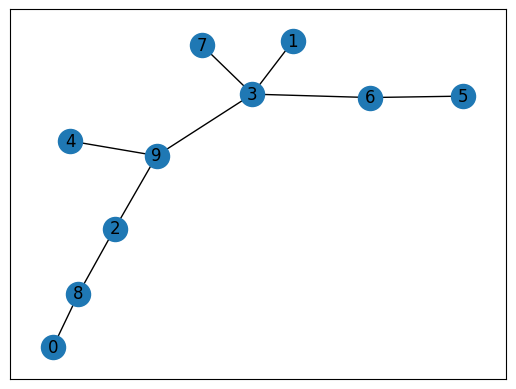

Energy = -3.936329187141873
Energy = -3.9363291871418733  (explicit)


In [8]:
N = 2 ## su(N) Lie-algebra
G = nx.random_tree(10) ## graph/network

## draw Graph/Network
nx.draw_networkx(G)
plt.show()

## generate Heisenberg Tensor-Network
TNO, TrRx = genTNO(G, N)
H_NN2 = Hamiltonian_NN2(TNO, TrRx, greedypath(G)) ## use greedy-contraction algorithm

## solve
E, Ψ = sparse.linalg.eigsh(H_NN2, 1, which='SA') ## 1==number of states desired
print("Energy = " + str(E[0])) ## in units of interaction J

## ⚠ explicit solve (if system is sufficiently small)
if len(G.nodes())<11 and N==2:
    A = np.triu(nx.adjacency_matrix(G).todense()) ## adjacency-matrix
    Eex,Ψex = Heisenberg_dense(A)
    print("Energy = " + str(Eex) + "  (explicit)")